In [8]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumBarunGothic'
)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({
    'font.size' : 10,
    'font.family': 'NanumBarunGothic'
})
plt.rc('font', family = 'NanumBarunGothic')

import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# 모든 컬럼을 출력하도록 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [9]:
import pandas as pd
import re

df = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_5.csv')
df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))
df['계약월'] = df['계약년월'].map(lambda x : int(str(x)[4:]))
df['전용면적'] = df['전용면적(㎡)']
df = df.drop(['계약년월', '전용면적(㎡)', '본번', '부번', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'address', 'address_apt', 'address_apt_sqm' ], axis=1)
df = df.rename(columns=lambda x: re.sub('k-', '', x))

df = df.drop(columns=['target'], axis=1)

for col in df.columns:
    if df[col].dtype == 'object':
        df = df.drop(columns=[col], axis=1)

train_df = df.query("is_test == 0")
test_df = df.query("is_test == 1")

print(df.columns)

Index(['계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적',
       '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과',
       '건축면적', '주차대수', 'is_test', 'latitude', 'longitude', '강남여부',
       'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', '계약년', '계약월', '전용면적'],
      dtype='object')


# Data

In [10]:
chunks = {}

for year in sorted(list(train_df["계약년"].unique())):
    chunks[year] = train_df[train_df["계약년"] == year]
    print(year, len(chunks[year]))

2007 58767
2008 57012
2009 73491
2010 44457
2011 54513
2012 40851
2013 67865
2014 85130
2015 119891
2016 99253
2017 104893
2018 81413
2019 74696
2020 83711
2021 43117
2022 12214
2023 17548


In [11]:
data = {}

drop_columns = ['계약년','mean_target_gu_dong','mean_target', 'apt_mean_target','address_mean_target', '강남여부']
for year in range(2007, 2024):
    concat = pd.concat([chunks[year], test_df])
    concat = concat.drop(columns=drop_columns)
    data[year] = concat

# Model

In [107]:
data[2023]

,계약일,층,건축년도,전체동수,전체세대수,연면적,주거전용면적,관리비부과면적,전용면적별세대현황(60㎡이하),전용면적별세대현황(60㎡~85㎡이하),85㎡~135㎡이하,135㎡초과,건축면적,주차대수,is_test,latitude,longitude,강남여부,계약월,전용면적
201009,29,8,2021,2.0,232.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,70.0,2724.46,305.0,0,37.484828,127.057251,1,6,105.8064
201010,3,10,1983,6.0,940.0,93810.0,65960.0,65960.0,190.0,750.0,0.0,70.0,6524.00,652.0,0,37.487623,127.068504,1,1,74.2500
201011,5,12,1983,6.0,940.0,93810.0,65960.0,65960.0,190.0,750.0,0.0,70.0,6524.00,652.0,0,37.487623,127.068504,1,2,61.1900
201012,7,13,1983,6.0,940.0,93810.0,65960.0,65960.0,190.0,750.0,0.0,70.0,6524.00,652.0,0,37.487623,127.068504,1,4,83.1700
201013,29,10,1983,6.0,940.0,93810.0,65960.0,65960.0,190.0,750.0,0.0,70.0,6524.00,652.0,0,37.487623,127.068504,1,4,83.1700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,19,13,2014,16.0,1402.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,70.0,14171.00,1568.0,1,37.617190,127.106452,0,7,84.6500
1128090,25,12,2014,16.0,1402.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,70.0,14171.00,1568.0,1,37.617190,127.106452,0,7,84.6200
1128091,27,12,2014,16.0,1402.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,70.0,14171.00,1568.0,1,37.617190,127.106452,0,8,101.6500
1128092,2,18,2014,16.0,1402.0,190866.0,93849.0,92808.0,808.0,504.0,90.0,70.0,14171.00,1568.0,1,37.617190,127.106452,0,9,84.9400


In [19]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

param = {
        'num_leaves': 50,
        'min_data_in_leaf': 30, 
        'objective':'binary',
        'max_depth': 5,
        'learning_rate': 0.001,
        "min_child_samples": 20,
        "boosting": "gbdt",
        "feature_fraction": 0.9,
        "bagging_freq": 1,
        "bagging_fraction": 0.9 ,
        "bagging_seed": 17,
        "metric": 'auc',
        "lambda_l1": 0.1,
        "verbosity": -1
}

def get_auc_roc(data):
        auc_roc_scores = {}

        for year in range(2007, 2024):
                X = data[year].drop(columns=['is_test'], axis=1)
                y = data[year]['is_test']

                folds = TimeSeriesSplit(n_splits=5, shuffle=True, random_state=15)
                scores = []

                for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
                        print(f'Fold {fold_}')
                        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
                        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
                        
                        model = LGBMClassifier(**param, n_estimators=100, random_state=42)
                        model.fit(
                                X_train, y_train,
                                eval_set=[(X_val, y_val)],
                                eval_metric='auc',
                                callbacks=[lgb.early_stopping(5)]
                        )
                
                y_pred = model.predict_proba(X_val)[:, 1]
                fold_score = roc_auc_score(y_val, y_pred)
                scores.append(fold_score)
                print(f'AUC: {fold_score}')

                print(f'\nYear {year}')
                print("교차 검증 점수:", scores)
                print("평균 AUC: %0.4f (+/- %0.4f)" % (np.mean(scores), np.std(scores) * 2))
                print('-'*100)
                
                auc_roc_scores[year] = {
                        'scores': scores,
                        'mean': np.mean(scores),
                        'std': np.std(scores)
                }

        return auc_roc_scores

results = get_auc_roc(data)

Fold 0
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.972289
Fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.974448
Fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.975518
Fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.975041
Fold 4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.973406
AUC: 0.973405859316667

Year 2007
교차 검증 점수: [0.973405859316667]
평균 AUC: 0.9734 (+/- 0.0000)
----------------------------------------------------------------------------------------------------
Fold 0
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.984108
Fold 1
Training until val

In [6]:
%%capture
auc_roc_score = get_auc_roc(data)

In [7]:
for year in range(2007, 2024):
    item = auc_roc_score[year]
    model, score = item['model'], item['score']
    print(year)
    print(f"auc score : {score}")
    
    for imp, feature in zip(model.feature_importances_, data[year].columns):
        print(feature, imp)
    print('-' * 100)

2007
auc score : 0.9907533574782112
계약일 24
층 0
건축년도 88
전체동수 74
전체세대수 3
연면적 59
주거전용면적 42
관리비부과면적 32
전용면적별세대현황(60㎡이하) 81
전용면적별세대현황(60㎡~85㎡이하) 68
85㎡~135㎡이하 53
135㎡초과 0
건축면적 84
주차대수 51
is_test 149
latitude 45
longitude 181
계약월 32
----------------------------------------------------------------------------------------------------
2008
auc score : 0.9945131166018367
계약일 14
층 7
건축년도 96
전체동수 42
전체세대수 20
연면적 32
주거전용면적 28
관리비부과면적 26
전용면적별세대현황(60㎡이하) 91
전용면적별세대현황(60㎡~85㎡이하) 97
85㎡~135㎡이하 40
135㎡초과 0
건축면적 75
주차대수 92
is_test 74
latitude 45
longitude 159
계약월 11
----------------------------------------------------------------------------------------------------
2009
auc score : 0.9833005659390797
계약일 31
층 15
건축년도 99
전체동수 85
전체세대수 33
연면적 64
주거전용면적 35
관리비부과면적 56
전용면적별세대현황(60㎡이하) 67
전용면적별세대현황(60㎡~85㎡이하) 86
85㎡~135㎡이하 60
135㎡초과 0
건축면적 74
주차대수 83
is_test 83
latitude 30
longitude 168
계약월 13
----------------------------------------------------------------------------------------------------
2010
auc score 

# mean_target_gu_dong 이 이상해요

In [83]:
df_test = data[2023].query('is_test == 0')
df_train = data[2023].query('is_test == 1')

df_test['address_mean_target']

201009     95816.372881
201010    105727.272727
201011    105727.272727
201012    105727.272727
201013    105727.272727
              ...      
394495     62063.160000
394496     40355.229672
394497     40355.229672
394498     40355.229672
394499     40355.229672
Name: address_mean_target, Length: 17548, dtype: float64

<Axes: xlabel='address_mean_target', ylabel='Count'>

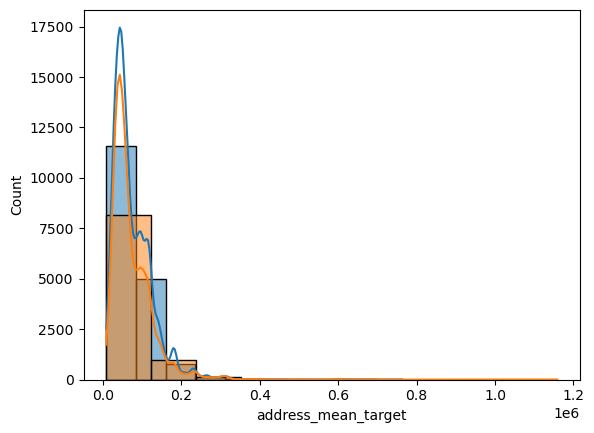

In [88]:
sns.histplot(data = df_test['address_mean_target'], bins=10, kde=True)
sns.histplot(data = df_train['address_mean_target'], bins=10, kde=True)
